<a href="https://colab.research.google.com/github/srmty09/Deep-Learning/blob/main/VAE/vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

In [30]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.0,), std=(1.0,))
])

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transforms)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transforms)


In [35]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, img_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.img_dim = img_dim
        self.enc_mu = nn.Linear(img_dim, latent_dim)
        self.enc_logvar = nn.Linear(img_dim, latent_dim)

    def forward(self, x):
        mu = self.enc_mu(x)
        logvar = self.enc_logvar(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z, mu, logvar

In [36]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, img_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.img_dim = img_dim
        self.dec = nn.Linear(latent_dim, img_dim)

    def forward(self, z):
        x = self.dec(z)
        return x

In [37]:
class VAE(nn.Module):
    def __init__(self, latent_dim, img_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.img_dim = img_dim

        self.encoder = Encoder(latent_dim, img_dim)
        self.decoder = Decoder(latent_dim, img_dim)

    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

    def loss_function(self, x_recon, x, mu, logvar):
        recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_loss

    def sample(self, num_samples, device='cpu'):
        """Generate new samples from the latent space"""
        z = torch.randn(num_samples, self.latent_dim).to(device)
        samples = self.decoder(z)
        return samples

In [38]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [39]:
def train_vae(vae, train_loader, test_loader, epochs=10, lr=1e-3, device='cpu'):
    vae = vae.to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        vae.train()
        train_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(x.size(0), -1).to(device)

            optimizer.zero_grad()
            x_recon, mu, logvar = vae(x)
            loss = vae.loss_function(x_recon, x, mu, logvar)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        vae.eval()
        test_loss = 0
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.view(x.size(0), -1).to(device)
                x_recon, mu, logvar = vae(x)
                loss = vae.loss_function(x_recon, x, mu, logvar)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(avg_test_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    return train_losses, test_losses

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [47]:
latent_dim = 30
img_dim = 28 * 28

vae = VAE(latent_dim=latent_dim, img_dim=img_dim)
train_losses, test_losses = train_vae(
    vae,
    train_loader,
    test_loader,
    epochs=20,
    lr=1e-4,
    device=device
)

Epoch 1/20, Train Loss: 167.7004, Test Loss: 103.3493
Epoch 2/20, Train Loss: 94.7036, Test Loss: 89.2596
Epoch 3/20, Train Loss: 84.2793, Test Loss: 78.7041
Epoch 4/20, Train Loss: 73.3770, Test Loss: 67.9442
Epoch 5/20, Train Loss: 63.5256, Test Loss: 59.1146
Epoch 6/20, Train Loss: 55.4017, Test Loss: 51.8121
Epoch 7/20, Train Loss: 49.6497, Test Loss: 47.6913
Epoch 8/20, Train Loss: 46.6175, Test Loss: 45.5745
Epoch 9/20, Train Loss: 45.1532, Test Loss: 44.4992
Epoch 10/20, Train Loss: 44.3081, Test Loss: 43.7582
Epoch 11/20, Train Loss: 43.5711, Test Loss: 43.0739
Epoch 12/20, Train Loss: 42.9733, Test Loss: 42.5106
Epoch 13/20, Train Loss: 42.4503, Test Loss: 41.9615
Epoch 14/20, Train Loss: 42.0126, Test Loss: 41.5789
Epoch 15/20, Train Loss: 41.6268, Test Loss: 41.2860
Epoch 16/20, Train Loss: 41.3413, Test Loss: 41.0121
Epoch 17/20, Train Loss: 41.1075, Test Loss: 40.7823
Epoch 18/20, Train Loss: 40.9513, Test Loss: 40.6266
Epoch 19/20, Train Loss: 40.7676, Test Loss: 40.5054


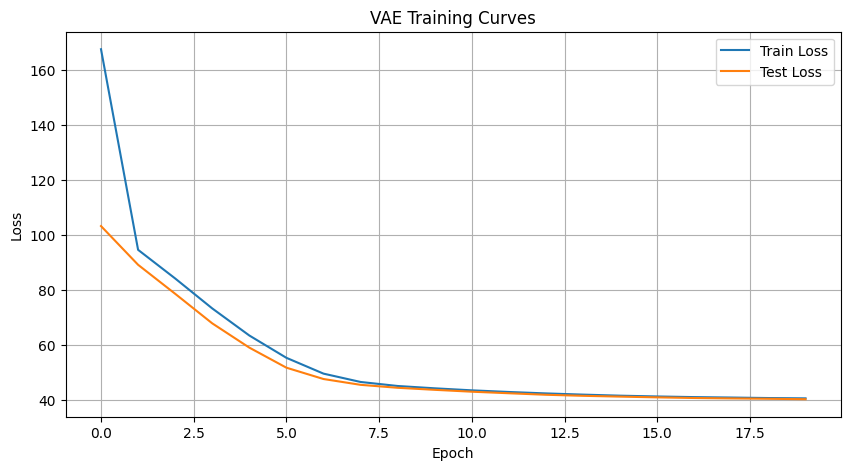

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('VAE Training Curves')
plt.grid(True)
plt.show()

In [49]:
def visualize_results(vae, test_loader, device='cpu', num_samples=10):
    vae.eval()
    with torch.no_grad():
        x, _ = next(iter(test_loader))
        x = x[:num_samples].view(num_samples, -1).to(device)

        x_recon, _, _ = vae(x)

        z = torch.randn(num_samples, vae.latent_dim).to(device)
        generated = vae.decoder(z)

        fig, axes = plt.subplots(3, num_samples, figsize=(15, 5))

        for i in range(num_samples):
            axes[0, i].imshow(x[i].cpu().view(28, 28), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title('Original', fontsize=12)

            axes[1, i].imshow(x_recon[i].cpu().view(28, 28), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title('Reconstructed', fontsize=12)

            axes[2, i].imshow(generated[i].cpu().view(28, 28), cmap='gray')
            axes[2, i].axis('off')
            if i == 0:
                axes[2, i].set_title('Generated', fontsize=12)

        plt.tight_layout()
        plt.show()

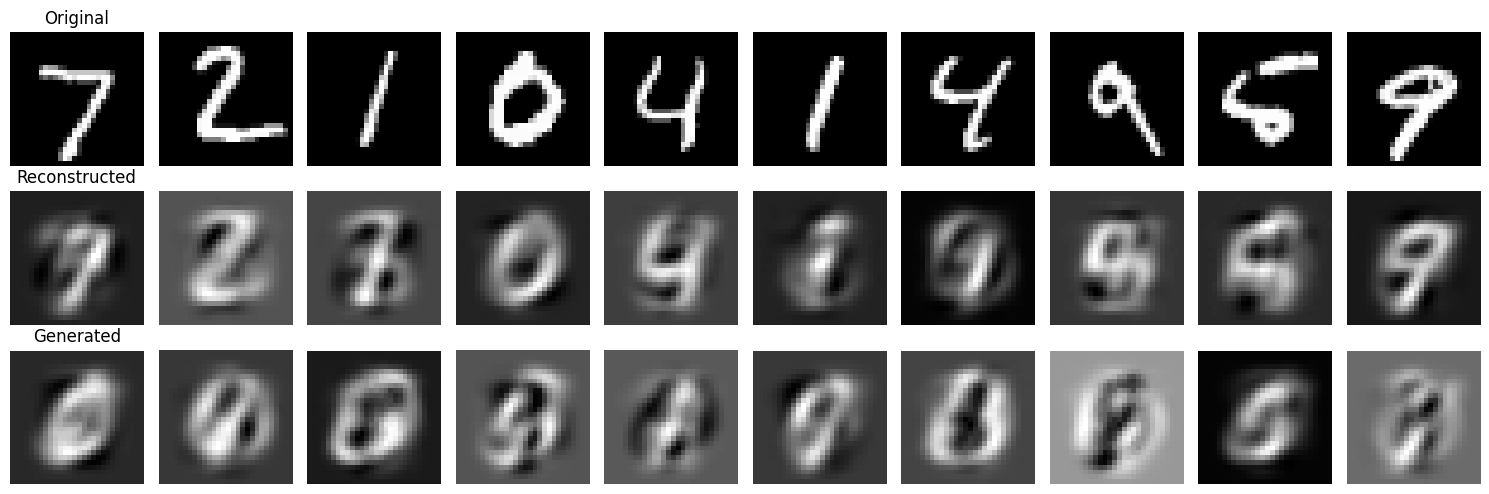

In [50]:
visualize_results(vae, test_loader, device=device)